# **Unsupervised Clustering of Japanse Candlesticks - Version 3.0.1**

---

**Author**: *Rogério Rabelo Ferreira Junior*

**Date**: *March 15, 2025*

**E-mail**: *r.rabelo.f7@gmail.com*


## Introduction

This project delves into the unsupervised clustering of candlestick patterns, aiming to uncover hidden structures and groupings within the data. By modeling features, the goal is to enable the model to effectively differentiate and cluster the data.



## Development of the Project

### Analysing and understanding the data
Before diving into complex modeling, it's crucial to first explore the data visually. This quick exploration provides invaluable insights, helping to understand the distribution, patterns, and potential anomalies that may influence clustering outcomes. By observing Japanese candlestick patterns directly, we can grasp the inherent variability within the data, guiding us in crafting features that effectively capture essential characteristics. This step not only accelerates hypothesis generation but also ensures that we remain aligned with the data’s real-world behavior before applying unsupervised learning techniques.

#### Importing relevant libraries

In [ ]:
!pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.8 MB/s eta 0:00:00


In [ ]:
pip install kneed scikit-learn pandas numpy matplotlib openpyxl

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.model_selection import ParameterGrid
from matplotlib.patches import Rectangle
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import plotly.graph_objects as go
import kagglehub
from kneed.knee_locator import KneeLocator

#### Importing data

In [ ]:
print("Pick the dataset:")
print("1: Netflix dataset")
print("2: Apple dataset")
selection = int(input("Enter 1 or 2: "))
# selection = 2
if (selection == 1):
  file_path = !wget --no-check-certificate 'https://docs.google.com/uc?id=1skOTwQq_jwgnY53WCsoOTA0b93ViftQV&export=download' -O NFLX.xlsx
  data = pd.read_excel('NFLX.xlsx')
elif (selection == 2):
  file_path = !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1-1ggHRh848SWQ9h6rYZjw7T0waAWkRbF' -O AAPL.csv
  data = pd.read_csv('AAPL.csv')
else:
  print("Error")

Pick the dataset:
1: Netflix dataset
2: Apple dataset
Enter 1 or 2: 1


In [ ]:
print("Data preview:")
data

Data preview:


,Date,Open,High,Low,Close
0,2022-06-03,200.139999,202.949997,198.050003,198.979996
1,2022-06-02,192.020004,205.470001,191.720001,205.089996
2,2022-06-01,198.699997,202.740005,191.660004,192.910004
3,2022-05-31,196.179993,199.949997,190.800003,197.440002
4,2022-05-27,193.190002,195.250000,190.369995,195.190002
...,...,...,...,...,...
5039,2002-05-30,1.107857,1.107857,1.071429,1.071429
5040,2002-05-29,1.164286,1.164286,1.085714,1.103571
5041,2002-05-28,1.213571,1.232143,1.157143,1.157143
5042,2002-05-24,1.214286,1.225000,1.197143,1.210000


In [ ]:
ar = data.apply(lambda row: 'red' if row['Close'] < row['Open'] else 'green', axis=1)
candle_counts = ar.value_counts()
overall_trend = 'upward' if data['Close'].iloc[0] > data['Close'].iloc[-1] else 'downward'
candle_counts, overall_trend

(red      2563
 green    2481
 Name: count, dtype: int64,
 'upward')

In [ ]:
data['Close'].iloc[0] - data['Close'].iloc[-1]

np.float64(197.783567)

From the insights above, we observe a significant growth trend over time. The difference between the last and first closing prices is 197.78, which represents a 150-fold increase compared to the first closing price. Additionally, the data reveals an almost equal distribution of red and green candlesticks, which are determined by the following condition:


\begin{cases}
\text{green} & \text{if } (\text{Close} - \text{Open}) > 0 \\
\text{red} & \text{otherwise}
\end{cases}


By applying this condition, we can generate a visual representation of candlesticks from our dataset for our first 30 candlesticks, as illustrated in the chart below.


In [ ]:
data['Date'] = pd.to_datetime(data['Date'], utc=True)

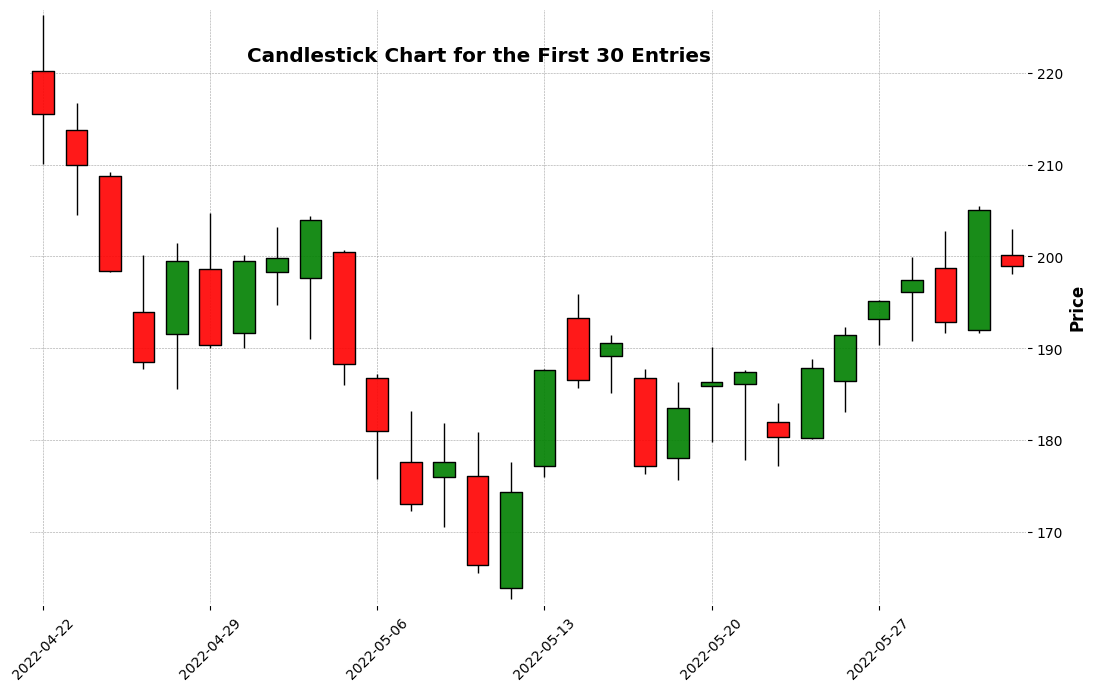

In [ ]:
def plot_candlestick_by_date(data, num_samples=30):

    candlestick_data = data.head(num_samples).copy()
    candlestick_data['Date'] = pd.to_datetime(candlestick_data['Date'])
    candlestick_data.set_index('Date', inplace=True)
    candlestick_data = candlestick_data.sort_index(ascending=True)

    custom_style = mpf.make_mpf_style(base_mpf_style='charles',
                                      marketcolors=mpf.make_marketcolors(up='g', down='r', wick='black', edge='black'),
                                      gridstyle="--",
                                      facecolor='white',
                                      rc={'font.size': 10})

    mpf.plot(candlestick_data,
             type='candle',
             style=custom_style,
             title='Candlestick Chart for the First 30 Entries',
             ylabel='Price',
             volume=False,
             datetime_format='%Y-%m-%d',
             figratio=(10, 6),
             figscale=1.2,
             tight_layout=True)
plot_candlestick_by_date(data)

### Studying our data

Japanese Candlesticks were originally developed to represent the price variations of rice over a specific time range, showing the highest price, the lowest price, the opening price, and the closing price, as shown in the Figure bellow.

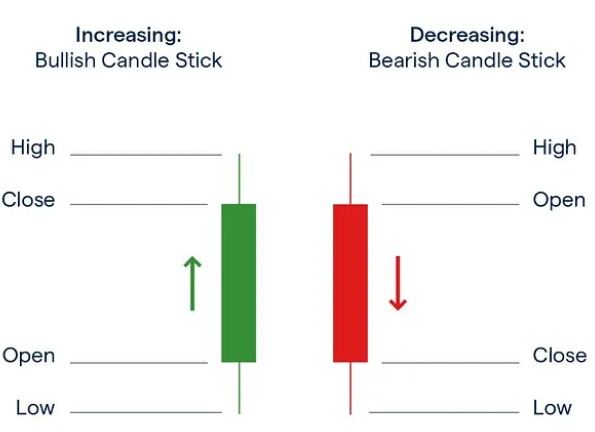

Our model will classify each component of the candlestick**—Body(%), Upper Shadow(%), and Lower Shadow(%)—**into one of four categories: insignificant, low, medium, or high. These classifications will be determined by an unsupervised model, with various algorithms tested to select the best fit. Each candlestick component will be classified independently, enabling the model to categorize candlesticks based on their proportional changes for each day.

Our model will ultimately have 128 different clusters. This is due to the combination of 4 different types for each component **—body, upper wick, and lower wick—** plus the bullish or bearish characteristic, resulting in 4 x 4 x 4 x 2 = 128. We are applying clustering layers to each variable individually, which structures the model like a tree, with each branch representing a unique combination of clusters.


Dados numéricos shape: (5044, 12)

Calculando métricas para diferentes números de clusters...
Clusters: 2 | Inércia: 36524.31 | Silhouette: 0.4900
Clusters: 3 | Inércia: 31621.29 | Silhouette: 0.2764
Clusters: 4 | Inércia: 27646.89 | Silhouette: 0.2871
Clusters: 5 | Inércia: 23794.63 | Silhouette: 0.3243
Clusters: 6 | Inércia: 22086.46 | Silhouette: 0.3256
Clusters: 7 | Inércia: 20411.87 | Silhouette: 0.3186
Clusters: 8 | Inércia: 19038.50 | Silhouette: 0.3237
Clusters: 9 | Inércia: 17702.58 | Silhouette: 0.3263
Clusters: 10 | Inércia: 17027.49 | Silhouette: 0.3195

ANÁLISE DOS MÉTODOS DE DETECÇÃO DO COTOVELO:
Método da Distância Perpendicular: 5 clusters
Método da Redução < 10%: 6 clusters
Melhor Silhouette Score: 2 clusters (score: 0.4900)


/tmp/ipython-input-3345190695.py:51: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  distance = np.abs(np.cross(p2-p1, p1-point)) / np.linalg.norm(p2-p1)


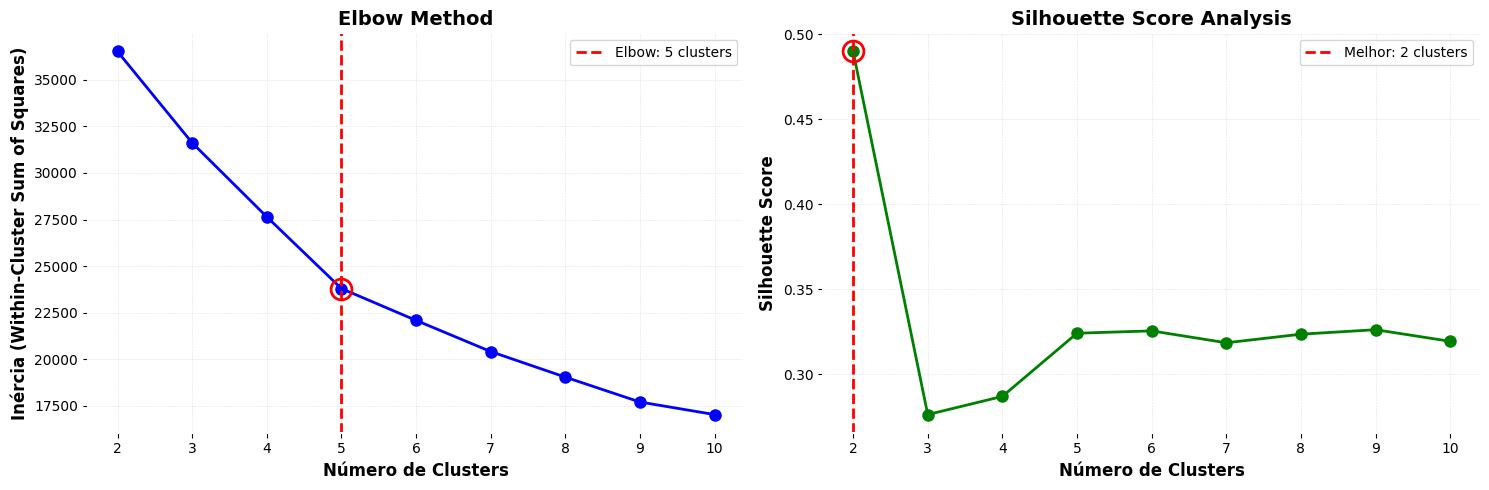


RECOMENDAÇÃO FINAL:
Com base nas análises:
  • Elbow visual (distância): 5 clusters
  • Melhor Silhouette Score: 2 clusters

RECOMENDAÇÃO: Testar com 5 ou 2 clusters



In [ ]:
# Preparação dos dados
numeric_data = data.select_dtypes(include=[np.number])
numeric_data = numeric_data.dropna()

print(f"\nDados numéricos shape: {numeric_data.shape}")

# Normalização dos dados
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Range de clusters para testar
min_clusters = 2
max_clusters = 10
cluster_range = range(min_clusters, max_clusters + 1)

# Listas para armazenar métricas
inertias = []
silhouette_scores = []

print("\nCalculando métricas para diferentes números de clusters...")

# Calcular métricas para cada número de clusters
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_data)

    inertias.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

    print(f"Clusters: {n_clusters} | Inércia: {kmeans.inertia_:.2f} | Silhouette: {silhouette_avg:.4f}")

# Converter para arrays numpy
inertias_array = np.array(inertias)
clusters_array = np.array(list(cluster_range))

# Método 1: Segunda derivada (taxa de aceleração)
first_derivative = np.diff(inertias_array)
second_derivative = np.diff(first_derivative)

# Método 2: Distância perpendicular (método da linha)
# Linha conectando primeiro e último ponto
p1 = np.array([clusters_array[0], inertias_array[0]])
p2 = np.array([clusters_array[-1], inertias_array[-1]])

# Calcular distâncias perpendiculares
distances = []
for i, k in enumerate(clusters_array):
    point = np.array([k, inertias_array[i]])
    # Distância do ponto à linha
    distance = np.abs(np.cross(p2-p1, p1-point)) / np.linalg.norm(p2-p1)
    distances.append(distance)

elbow_distance = clusters_array[np.argmax(distances)]

# Método 3: Redução percentual da inércia
percentage_reduction = []
for i in range(len(inertias_array) - 1):
    reduction = (inertias_array[i] - inertias_array[i+1]) / inertias_array[i] * 100
    percentage_reduction.append(reduction)

# Encontrar onde a redução fica menor que um limiar (ex: 10%)
threshold = 10
elbow_percentage = None
for i, reduction in enumerate(percentage_reduction):
    if reduction < threshold:
        elbow_percentage = clusters_array[i+1]
        break

# Melhor Silhouette Score
best_silhouette_idx = np.argmax(silhouette_scores)
best_silhouette_clusters = clusters_array[best_silhouette_idx]

print(f"\n{'='*70}")
print(f"ANÁLISE DOS MÉTODOS DE DETECÇÃO DO COTOVELO:")
print(f"{'='*70}")
print(f"Método da Distância Perpendicular: {elbow_distance} clusters")
print(f"Método da Redução < {threshold}%: {elbow_percentage} clusters")
print(f"Melhor Silhouette Score: {best_silhouette_clusters} clusters (score: {silhouette_scores[best_silhouette_idx]:.4f})")
print(f"{'='*70}")

# Criar visualizações
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico 1: Elbow Method
axes[0].plot(clusters_array, inertias_array, 'bo-', linewidth=2, markersize=8)
axes[0].axvline(x=elbow_distance, color='red', linestyle='--', linewidth=2,
                label=f'Elbow: {elbow_distance} clusters')
axes[0].plot(elbow_distance, inertias_array[elbow_distance - min_clusters], 'ro',
             markersize=15, markerfacecolor='none', markeredgewidth=2)
axes[0].set_xlabel('Número de Clusters', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Inércia (Within-Cluster Sum of Squares)', fontsize=12, fontweight='bold')
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=10)
axes[0].set_xticks(clusters_array)

# Gráfico 2: Silhouette Score
axes[1].plot(clusters_array, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[1].axvline(x=best_silhouette_clusters, color='red', linestyle='--', linewidth=2,
                label=f'Melhor: {best_silhouette_clusters} clusters')
axes[1].plot(best_silhouette_clusters, silhouette_scores[best_silhouette_idx], 'ro',
             markersize=15, markerfacecolor='none', markeredgewidth=2)
axes[1].set_xlabel('Número de Clusters', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[1].set_title('Silhouette Score Analysis', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend(fontsize=10)
axes[1].set_xticks(clusters_array)

plt.tight_layout()
plt.show()

# Recomendação final
print(f"\n{'='*70}")
print(f"RECOMENDAÇÃO FINAL:")
print(f"{'='*70}")
print(f"Com base nas análises:")
print(f"  • Elbow visual (distância): {elbow_distance} clusters")
print(f"  • Melhor Silhouette Score: {best_silhouette_clusters} clusters")
print(f"\nRECOMENDAÇÃO: Testar com {elbow_distance} ou {best_silhouette_clusters} clusters")
print(f"{'='*70}\n")

### Data modificiation

From this, we can derive several variables, which will be calculated using the equations outlined below. These variables primarily represent key measurements such as the sizes of the shadows (upper and lower) and the body of the candlestick. These measurements are crucial, as they provide valuable insights into the overall structure of each candlestick, enabling us to quantify the proportions and characteristics that define different patterns. **This vairables won't be used directly for classifying, it's just a step to get the really valiable features**

* **Upper Shadow**:

The upper shadow is the difference between the highest price (`High`) and the maximum of either the opening price (`Open`) or the closing price (`Close`).


$$ \text{Upper shadow} = \text{High} - \max(\text{Open}, \text{Close}) $$


* **Lower shadow**

The lower shadow is the difference between the minimum of either the opening price (`Open`) or the closing price (`Close`) and the lowest price (`Low`).

$$ \text{Lower shadow} = \min(\text{Open}, \text{Close}) - \text{Low} $$

* **Body size**

The body size is the absolute difference between the closing price (`Close`) and the opening price (`Open`).

$$ \text{Body size} = \max(\text{Open}, \text{Close}) - \min(\text{Open}, \text{Close}) $$

In [ ]:
# Creating new data
data['Body_size'] = abs(data['Close'] - data['Open'])
data['Upper_shadow'] = data['High'] - data[['Open', 'Close']].max(axis=1)
data['Lower_shadow'] = data[['Open', 'Close']].min(axis=1) - data['Low']
data

,Date,Open,High,Low,Close,Body_size,Upper_shadow,Lower_shadow
0,2022-06-03 00:00:00+00:00,200.139999,202.949997,198.050003,198.979996,1.160003,2.809998,0.929993
1,2022-06-02 00:00:00+00:00,192.020004,205.470001,191.720001,205.089996,13.069992,0.380005,0.300003
2,2022-06-01 00:00:00+00:00,198.699997,202.740005,191.660004,192.910004,5.789993,4.040008,1.250000
3,2022-05-31 00:00:00+00:00,196.179993,199.949997,190.800003,197.440002,1.260009,2.509995,5.379990
4,2022-05-27 00:00:00+00:00,193.190002,195.250000,190.369995,195.190002,2.000000,0.059998,2.820007
...,...,...,...,...,...,...,...,...
5039,2002-05-30 00:00:00+00:00,1.107857,1.107857,1.071429,1.071429,0.036428,0.000000,0.000000
5040,2002-05-29 00:00:00+00:00,1.164286,1.164286,1.085714,1.103571,0.060715,0.000000,0.017857
5041,2002-05-28 00:00:00+00:00,1.213571,1.232143,1.157143,1.157143,0.056428,0.018572,0.000000
5042,2002-05-24 00:00:00+00:00,1.214286,1.225000,1.197143,1.210000,0.004286,0.010714,0.012857


Now, we can create percentual variables that describe the contribution of each component—such as the upper shadow, lower shadow, and body—relative to the openning of the candlestick. These percentual variables provide the model with more detailed information about the overall structure of each candlestick, allowing for a better understanding of the relationships between the different parts of the candlestick and its total size. The formulas used to calculate these proportions are as follows:

* **L_body**:

This represents the length of the body as a percentage of the opening of the candlestick.

$$
L_{\text{body}} = \left( \frac{\text{Body}}{\text{Open}} \right) \times 100
$$

* **L_upper**:

This represents the length of the upper shadow as a percentage of the opening of the candlestick.

$$
L_{\text{upper}} = \left( \frac{\text{Upper shadow}}{\text{Open}} \right) \times 100
$$

* **L_lower**:

This represents the length of the lower shadow as a percentage of the opening of the candlestick.

$$
L_{\text{lower}} = \left( \frac{\text{Lower shadow}}{\text{Open}} \right) \times 100
$$

These percentual variables are crucial for normalizing the size of the different components of each candlestick, making the data more comparable across different candles, regardless of their absolute values.


In [ ]:
data['L_body'] = ((data['Body_size']) / (data['Open'])) *100
data['L_upper'] = ((data['Upper_shadow']) / (data['Open'])) *100
data['L_lower'] = ((data['Lower_shadow']) / (data['Open'])) *100
data

,Date,Open,High,Low,Close,Body_size,Upper_shadow,Lower_shadow,L_body,L_upper,L_lower
0,2022-06-03 00:00:00+00:00,200.139999,202.949997,198.050003,198.979996,1.160003,2.809998,0.929993,0.579596,1.404016,0.464671
1,2022-06-02 00:00:00+00:00,192.020004,205.470001,191.720001,205.089996,13.069992,0.380005,0.300003,6.806578,0.197899,0.156235
2,2022-06-01 00:00:00+00:00,198.699997,202.740005,191.660004,192.910004,5.789993,4.040008,1.250000,2.913937,2.033220,0.629089
3,2022-05-31 00:00:00+00:00,196.179993,199.949997,190.800003,197.440002,1.260009,2.509995,5.379990,0.642272,1.279435,2.742374
4,2022-05-27 00:00:00+00:00,193.190002,195.250000,190.369995,195.190002,2.000000,0.059998,2.820007,1.035250,0.031056,1.459706
...,...,...,...,...,...,...,...,...,...,...,...
5039,2002-05-30 00:00:00+00:00,1.107857,1.107857,1.071429,1.071429,0.036428,0.000000,0.000000,3.288150,0.000000,0.000000
5040,2002-05-29 00:00:00+00:00,1.164286,1.164286,1.085714,1.103571,0.060715,0.000000,0.017857,5.214784,0.000000,1.533730
5041,2002-05-28 00:00:00+00:00,1.213571,1.232143,1.157143,1.157143,0.056428,0.018572,0.000000,4.649749,1.530360,0.000000
5042,2002-05-24 00:00:00+00:00,1.214286,1.225000,1.197143,1.210000,0.004286,0.010714,0.012857,0.352965,0.882329,1.058812


We can also create a variable to classify whether the candlestick is green or red, indicating whether the closing price is higher or lower than the opening price, like we did in the beginning. This variable (**W_B**) can be defined as follows: if the closing price is greater than the opening price, the candlestick is green (bullish); otherwise, it is red (bearish). We can use this to separathe the clusters found into two different groups, 10 beeing bullish and -10 beeing bearish. The value 10 was selected arbitrarily to create clusters that are significantly distant from each other, allowing the model to more clearly distinguish the substantial differences between them.

In [ ]:
data['W_B'] = data.apply(lambda row: 10 if row['Close'] > row['Open'] else -10, axis=1)
data

,Date,Open,High,Low,Close,Body_size,Upper_shadow,Lower_shadow,L_body,L_upper,L_lower,W_B
0,2022-06-03 00:00:00+00:00,200.139999,202.949997,198.050003,198.979996,1.160003,2.809998,0.929993,0.579596,1.404016,0.464671,-10
1,2022-06-02 00:00:00+00:00,192.020004,205.470001,191.720001,205.089996,13.069992,0.380005,0.300003,6.806578,0.197899,0.156235,10
2,2022-06-01 00:00:00+00:00,198.699997,202.740005,191.660004,192.910004,5.789993,4.040008,1.250000,2.913937,2.033220,0.629089,-10
3,2022-05-31 00:00:00+00:00,196.179993,199.949997,190.800003,197.440002,1.260009,2.509995,5.379990,0.642272,1.279435,2.742374,10
4,2022-05-27 00:00:00+00:00,193.190002,195.250000,190.369995,195.190002,2.000000,0.059998,2.820007,1.035250,0.031056,1.459706,10
...,...,...,...,...,...,...,...,...,...,...,...,...
5039,2002-05-30 00:00:00+00:00,1.107857,1.107857,1.071429,1.071429,0.036428,0.000000,0.000000,3.288150,0.000000,0.000000,-10
5040,2002-05-29 00:00:00+00:00,1.164286,1.164286,1.085714,1.103571,0.060715,0.000000,0.017857,5.214784,0.000000,1.533730,-10
5041,2002-05-28 00:00:00+00:00,1.213571,1.232143,1.157143,1.157143,0.056428,0.018572,0.000000,4.649749,1.530360,0.000000,-10
5042,2002-05-24 00:00:00+00:00,1.214286,1.225000,1.197143,1.210000,0.004286,0.010714,0.012857,0.352965,0.882329,1.058812,-10


### Selecting and processing

Now that we have declared the variables we believe are necessary for classification, we need to carefully examine our data and determine whether to include each variable in our model. For example, since our dataset is not time-based, we can simply ignore any time-related features and set them aside.

This analysis will be applied to all features, considering whether it is reasonable and beneficial to use each feature for classifying our data. We should ask questions such as:

- Does the feature provide meaningful information?
- Is it correlated with the target variable?
- Does it enhance the model's performance?
- Are there any potential issues with multicollinearity among the features?

By systematically evaluating each variable, we can ensure that our model is both efficient and effective in classifying the candlestick patterns.

In [ ]:
numeric_data = data.select_dtypes(include=['float64', 'int64'])
if numeric_data.isnull().values.any():
    numeric_data = numeric_data.fillna(numeric_data.mean())

In [ ]:
numeric_data.head(15)

,Open,High,Low,Close,Body_size,Upper_shadow,Lower_shadow,L_body,L_upper,L_lower,W_B
0,200.139999,202.949997,198.050003,198.979996,1.160003,2.809998,0.929993,0.579596,1.404016,0.464671,-10
1,192.020004,205.470001,191.720001,205.089996,13.069992,0.380005,0.300003,6.806578,0.197899,0.156235,10
2,198.699997,202.740005,191.660004,192.910004,5.789993,4.040008,1.250000,2.913937,2.033220,0.629089,-10
3,196.179993,199.949997,190.800003,197.440002,1.260009,2.509995,5.379990,0.642272,1.279435,2.742374,10
4,193.190002,195.250000,190.369995,195.190002,2.000000,0.059998,2.820007,1.035250,0.031056,1.459706,10
5,186.490005,192.339996,183.089996,191.399994,4.909989,0.940002,3.400009,2.632843,0.504050,1.823159,10
6,180.279999,188.869995,180.169998,187.830002,7.550003,1.039993,0.110001,4.187932,0.576877,0.061017,10
7,182.000000,184.000000,177.169998,180.339996,1.660004,2.000000,3.169998,0.912090,1.098901,1.741757,-10
8,186.149994,187.660004,177.889999,187.440002,1.290008,0.220002,8.259995,0.692994,0.118185,4.437279,10
9,185.869995,190.190002,179.770004,186.350006,0.480011,3.839996,6.099991,0.258251,2.065958,3.281859,10


In [ ]:
numeric_data.tail(15)

,Open,High,Low,Close,Body_size,Upper_shadow,Lower_shadow,L_body,L_upper,L_lower,W_B
5029,1.104286,1.122143,1.080000,1.082857,0.021429,0.017857,0.002857,1.940530,1.617063,0.258719,-10
5030,1.153571,1.182143,1.089286,1.092857,0.060714,0.028572,0.003571,5.263135,2.476831,0.309560,-10
5031,1.156429,1.188571,1.128571,1.153571,0.002858,0.032142,0.025000,0.247140,2.779418,2.161827,-10
5032,1.135000,1.175000,1.134286,1.156429,0.021429,0.018571,0.000714,1.888018,1.636211,0.062907,10
5033,1.177857,1.177857,1.103571,1.118571,0.059286,0.000000,0.015000,5.033378,0.000000,1.273499,-10
5034,1.150000,1.232143,1.148571,1.182143,0.032143,0.050000,0.001429,2.795043,4.347826,0.124261,10
5035,1.110714,1.159286,1.107143,1.147143,0.036429,0.012143,0.003571,3.279782,1.093261,0.321505,10
5036,1.135714,1.140000,1.110714,1.117857,0.017857,0.004286,0.007143,1.572315,0.377384,0.628944,-10
5037,1.080000,1.149286,1.076429,1.128571,0.048571,0.020715,0.003571,4.497315,1.918056,0.330648,10
5038,1.078571,1.078571,1.071429,1.076429,0.002142,0.000000,0.005000,0.198596,0.000000,0.463576,-10


There is no compelling reason to use the values of Open, High, Low, and Close in our analysis, as these values tend to grow over time. This temporal increase can negatively impact the model's performance, leading it to identify patterns that do not accurately represent our objective of clustering different types of candlesticks.

Instead of relying on these absolute values, we should focus on relative measurements and proportional variables that capture the structure and characteristics of the candlesticks without being influenced by their historical price levels. This approach will help ensure that our model effectively groups similar candlestick patterns while avoiding misleading results.

Given that, we can simply drop them.


In [ ]:
numeric_data = numeric_data.drop(columns=['Open', 'High', 'Low', 'Close'], axis = 1)

Now, analyzing the calculated variables, we can conclude that some of them are no longer useful since we have already calculated the proportions. As illustrated in the cluster goal images below, our objective is to separate the candlesticks based on their proportions rather than their absolute measurements.

Therefore, we can drop the following columns from our dataset: 'Upper_shadow', 'Lower_shadow', 'Body_size'. By focusing solely on the percentual variables, we can improve our model's ability to effectively cluster different types of candlestick patterns without the influence of their absolute sizes.


In [ ]:
numeric_data = numeric_data.drop(columns=['Upper_shadow', 'Lower_shadow', 'Body_size'], axis = 1)

In [ ]:
numeric_data.head(15)

,L_body,L_upper,L_lower,W_B
0,0.579596,1.404016,0.464671,-10
1,6.806578,0.197899,0.156235,10
2,2.913937,2.033220,0.629089,-10
3,0.642272,1.279435,2.742374,10
4,1.035250,0.031056,1.459706,10
5,2.632843,0.504050,1.823159,10
6,4.187932,0.576877,0.061017,10
7,0.912090,1.098901,1.741757,-10
8,0.692994,0.118185,4.437279,10
9,0.258251,2.065958,3.281859,10


## Clustering the body

Now, we will perform clustering based on the body percentage change and the W_B' variable, which indicates whether the candlestick is bullish or bearish. This first cluster layer is going to set apart different types of body, which is going to solve 33% of our problem.

In [ ]:
body_data = numeric_data[['L_body', 'W_B']]
body_data

,L_body,W_B
0,0.579596,-10
1,6.806578,10
2,2.913937,-10
3,0.642272,10
4,1.035250,10
...,...,...
5039,3.288150,-10
5040,5.214784,-10
5041,4.649749,-10
5042,0.352965,-10



Dados numéricos shape: (5044, 12)

Calculando métricas para diferentes números de clusters...
Clusters: 2 | Inércia: 36524.31 | Silhouette: 0.4900
Clusters: 3 | Inércia: 31621.29 | Silhouette: 0.2764
Clusters: 4 | Inércia: 27646.89 | Silhouette: 0.2871
Clusters: 5 | Inércia: 23794.63 | Silhouette: 0.3243
Clusters: 6 | Inércia: 22086.46 | Silhouette: 0.3256
Clusters: 7 | Inércia: 20411.87 | Silhouette: 0.3186
Clusters: 8 | Inércia: 19038.50 | Silhouette: 0.3237
Clusters: 9 | Inércia: 17702.58 | Silhouette: 0.3263
Clusters: 10 | Inércia: 17027.49 | Silhouette: 0.3195

ANÁLISE DOS MÉTODOS DE DETECÇÃO DO COTOVELO:
Método da Distância Perpendicular: 5 clusters
Método da Redução < 10%: 6 clusters
Melhor Silhouette Score: 2 clusters (score: 0.4900)


/tmp/ipython-input-3345190695.py:51: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  distance = np.abs(np.cross(p2-p1, p1-point)) / np.linalg.norm(p2-p1)


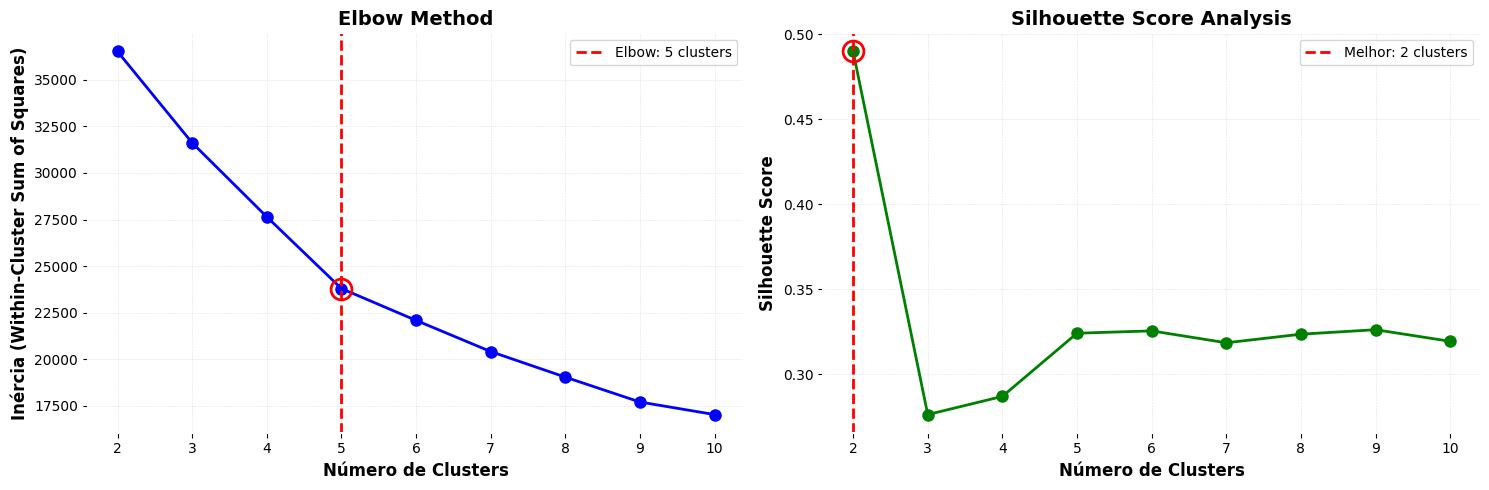


RECOMENDAÇÃO FINAL:
Com base nas análises:
  • Elbow visual (distância): 5 clusters
  • Melhor Silhouette Score: 2 clusters

RECOMENDAÇÃO: Testar com 5 ou 2 clusters



In [ ]:
# Preparação dos dados
numeric_data = data.select_dtypes(include=[np.number])
numeric_data = numeric_data.dropna()

print(f"\nDados numéricos shape: {numeric_data.shape}")

# Normalização dos dados
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Range de clusters para testar
min_clusters = 2
max_clusters = 10
cluster_range = range(min_clusters, max_clusters + 1)

# Listas para armazenar métricas
inertias = []
silhouette_scores = []

print("\nCalculando métricas para diferentes números de clusters...")

# Calcular métricas para cada número de clusters
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_data)

    inertias.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

    print(f"Clusters: {n_clusters} | Inércia: {kmeans.inertia_:.2f} | Silhouette: {silhouette_avg:.4f}")

# Converter para arrays numpy
inertias_array = np.array(inertias)
clusters_array = np.array(list(cluster_range))

# Método 1: Segunda derivada (taxa de aceleração)
first_derivative = np.diff(inertias_array)
second_derivative = np.diff(first_derivative)

# Método 2: Distância perpendicular (método da linha)
# Linha conectando primeiro e último ponto
p1 = np.array([clusters_array[0], inertias_array[0]])
p2 = np.array([clusters_array[-1], inertias_array[-1]])

# Calcular distâncias perpendiculares
distances = []
for i, k in enumerate(clusters_array):
    point = np.array([k, inertias_array[i]])
    # Distância do ponto à linha
    distance = np.abs(np.cross(p2-p1, p1-point)) / np.linalg.norm(p2-p1)
    distances.append(distance)

elbow_distance = clusters_array[np.argmax(distances)]

# Método 3: Redução percentual da inércia
percentage_reduction = []
for i in range(len(inertias_array) - 1):
    reduction = (inertias_array[i] - inertias_array[i+1]) / inertias_array[i] * 100
    percentage_reduction.append(reduction)

# Encontrar onde a redução fica menor que um limiar (ex: 10%)
threshold = 10
elbow_percentage = None
for i, reduction in enumerate(percentage_reduction):
    if reduction < threshold:
        elbow_percentage = clusters_array[i+1]
        break

# Melhor Silhouette Score
best_silhouette_idx = np.argmax(silhouette_scores)
best_silhouette_clusters = clusters_array[best_silhouette_idx]

print(f"\n{'='*70}")
print(f"ANÁLISE DOS MÉTODOS DE DETECÇÃO DO COTOVELO:")
print(f"{'='*70}")
print(f"Método da Distância Perpendicular: {elbow_distance} clusters")
print(f"Método da Redução < {threshold}%: {elbow_percentage} clusters")
print(f"Melhor Silhouette Score: {best_silhouette_clusters} clusters (score: {silhouette_scores[best_silhouette_idx]:.4f})")
print(f"{'='*70}")

# Criar visualizações
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico 1: Elbow Method
axes[0].plot(clusters_array, inertias_array, 'bo-', linewidth=2, markersize=8)
axes[0].axvline(x=elbow_distance, color='red', linestyle='--', linewidth=2,
                label=f'Elbow: {elbow_distance} clusters')
axes[0].plot(elbow_distance, inertias_array[elbow_distance - min_clusters], 'ro',
             markersize=15, markerfacecolor='none', markeredgewidth=2)
axes[0].set_xlabel('Número de Clusters', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Inércia (Within-Cluster Sum of Squares)', fontsize=12, fontweight='bold')
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=10)
axes[0].set_xticks(clusters_array)

# Gráfico 2: Silhouette Score
axes[1].plot(clusters_array, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[1].axvline(x=best_silhouette_clusters, color='red', linestyle='--', linewidth=2,
                label=f'Melhor: {best_silhouette_clusters} clusters')
axes[1].plot(best_silhouette_clusters, silhouette_scores[best_silhouette_idx], 'ro',
             markersize=15, markerfacecolor='none', markeredgewidth=2)
axes[1].set_xlabel('Número de Clusters', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[1].set_title('Silhouette Score Analysis', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend(fontsize=10)
axes[1].set_xticks(clusters_array)

plt.tight_layout()
plt.show()

# Recomendação final
print(f"\n{'='*70}")
print(f"RECOMENDAÇÃO FINAL:")
print(f"{'='*70}")
print(f"Com base nas análises:")
print(f"  • Elbow visual (distância): {elbow_distance} clusters")
print(f"  • Melhor Silhouette Score: {best_silhouette_clusters} clusters")
print(f"\nRECOMENDAÇÃO: Testar com {elbow_distance} ou {best_silhouette_clusters} clusters")
print(f"{'='*70}\n")

The model selects 8 different clusters, as previously mentioned, we are considering 4 types of body sizes, and by distinguishing them further based on their directional characteristic (bullish or bearish), we arrive at 4 x 2 = 8 clusters. This reasoning explains our choice of 8 clusters.

In [ ]:
# Dividing it by big, medium, low and very low
kmeans = KMeans(n_clusters = 10, random_state = 42)
kmeans.fit(body_data)
body_data['Cluster'] = kmeans.labels_

/tmp/ipython-input-2512633797.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  body_data['Cluster'] = kmeans.labels_


In [ ]:
body_data

,L_body,W_B,Cluster
0,0.579596,-10,4
1,6.806578,10,8
2,2.913937,-10,1
3,0.642272,10,2
4,1.035250,10,2
...,...,...,...
5039,3.288150,-10,6
5040,5.214784,-10,6
5041,4.649749,-10,6
5042,0.352965,-10,4


In [ ]:
body_data['Cluster'].unique()

array([4, 8, 1, 2, 0, 6, 9, 3, 5, 7], dtype=int32)

In [ ]:
body_data.loc[:,'W_B'] = body_data['W_B'].replace({-10: 'Bearish', 10: 'Bullish'})
body_data

/tmp/ipython-input-3112957399.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Bearish' 'Bullish' 'Bearish' ... 'Bearish' 'Bearish' 'Bullish']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  body_data.loc[:,'W_B'] = body_data['W_B'].replace({-10: 'Bearish', 10: 'Bullish'})


,L_body,W_B,Cluster
0,0.579596,Bearish,4
1,6.806578,Bullish,8
2,2.913937,Bearish,1
3,0.642272,Bullish,2
4,1.035250,Bullish,2
...,...,...,...
5039,3.288150,Bearish,6
5040,5.214784,Bearish,6
5041,4.649749,Bearish,6
5042,0.352965,Bearish,4


In [ ]:
bearish_data = body_data[body_data['W_B'] == 'Bearish']
bullish_data = body_data[body_data['W_B'] == 'Bullish']
bearish_data

,L_body,W_B,Cluster
0,0.579596,Bearish,4
2,2.913937,Bearish,1
7,0.912090,Bearish,4
11,5.103898,Bearish,6
13,3.512679,Bearish,6
...,...,...,...
5038,0.198596,Bearish,4
5039,3.288150,Bearish,6
5040,5.214784,Bearish,6
5041,4.649749,Bearish,6


In [ ]:
clusters_bearish = bearish_data['Cluster'].unique()
clusters_bullish = bullish_data['Cluster'].unique()
clusters_bearish

array([4, 1, 6, 9, 5], dtype=int32)

In [ ]:
clusters_bullish

array([8, 2, 0, 3, 7], dtype=int32)

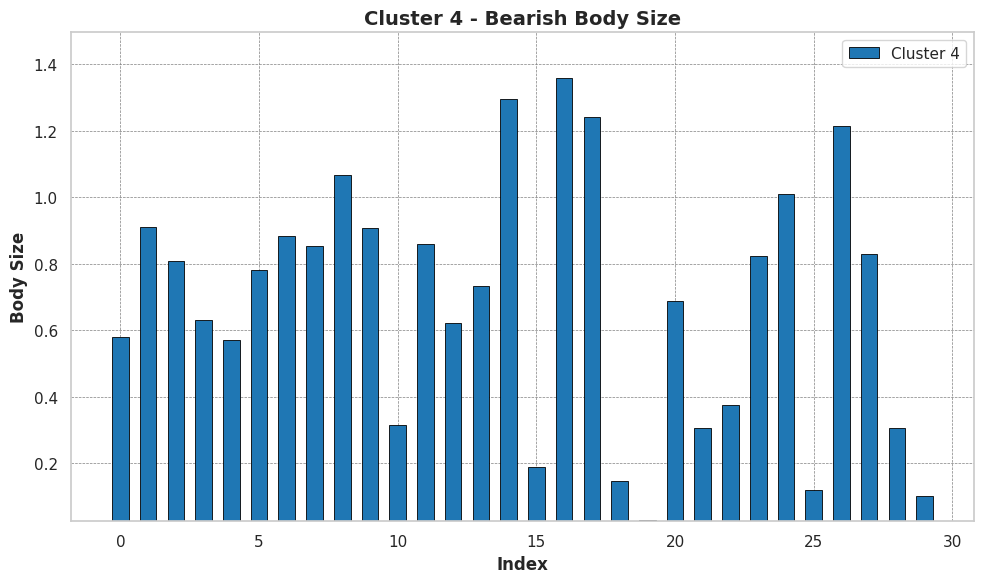

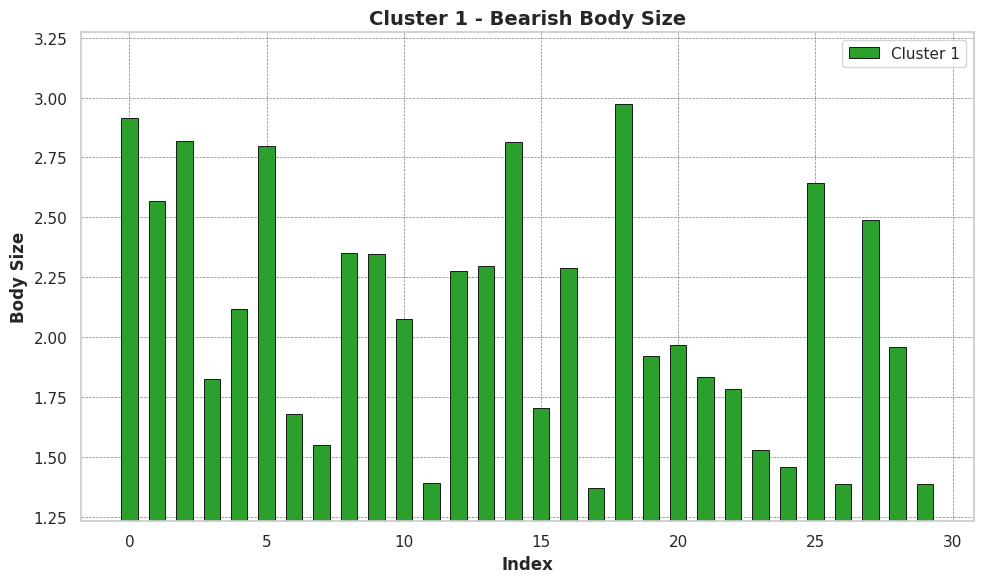

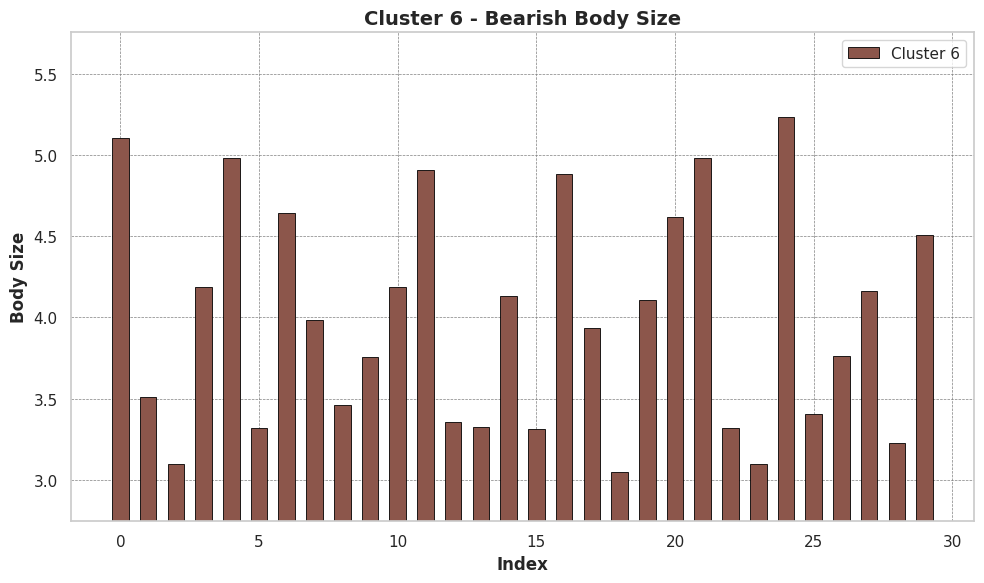

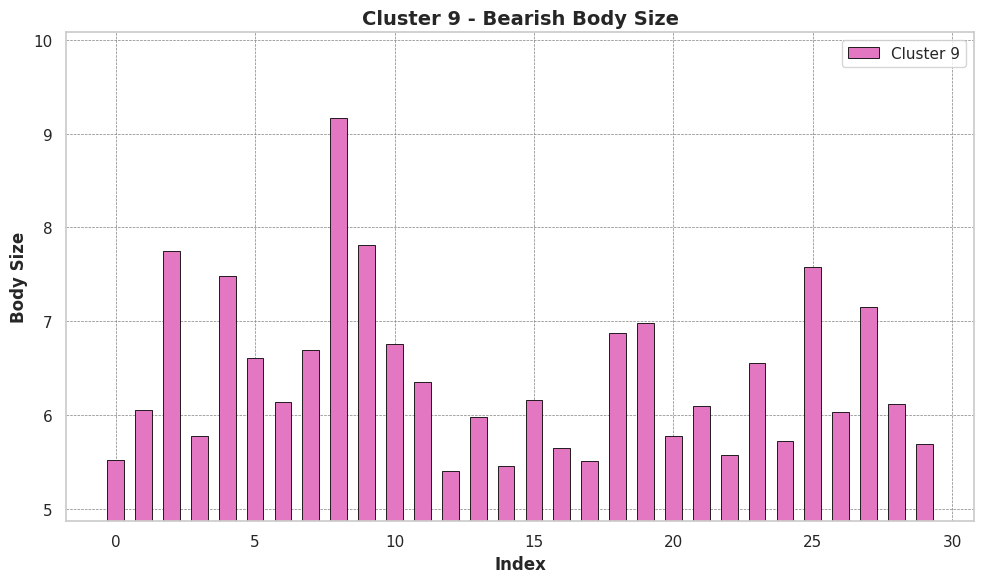

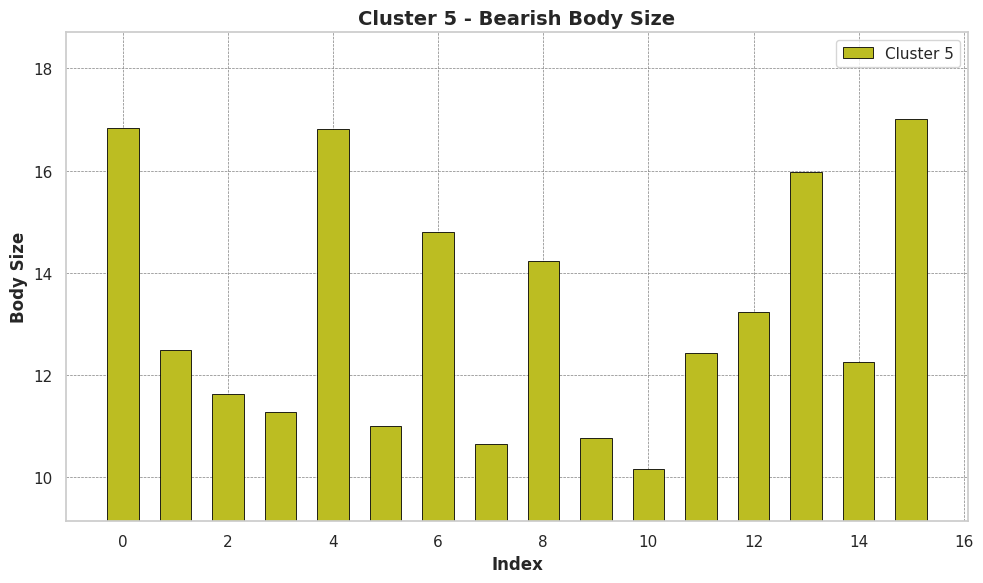

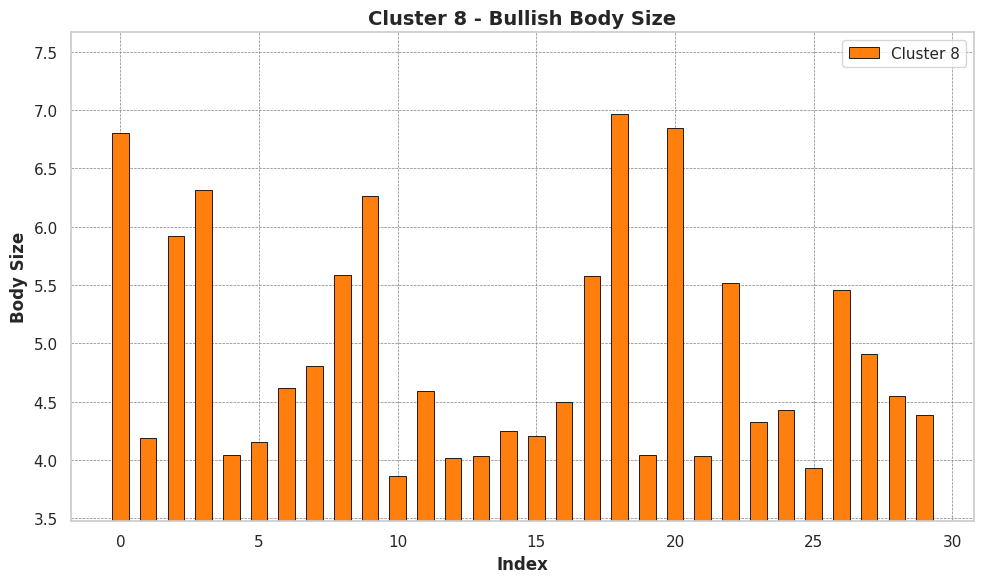

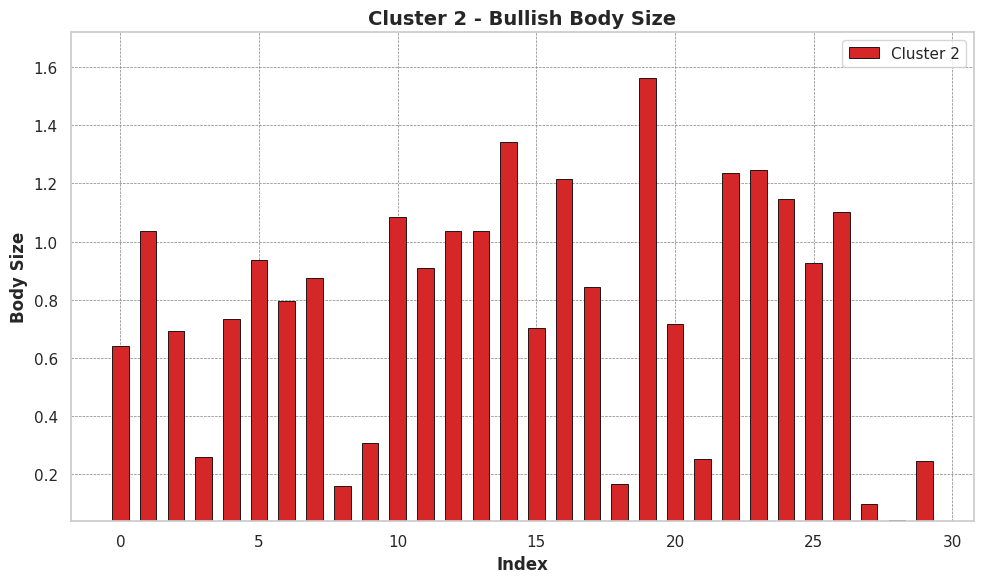

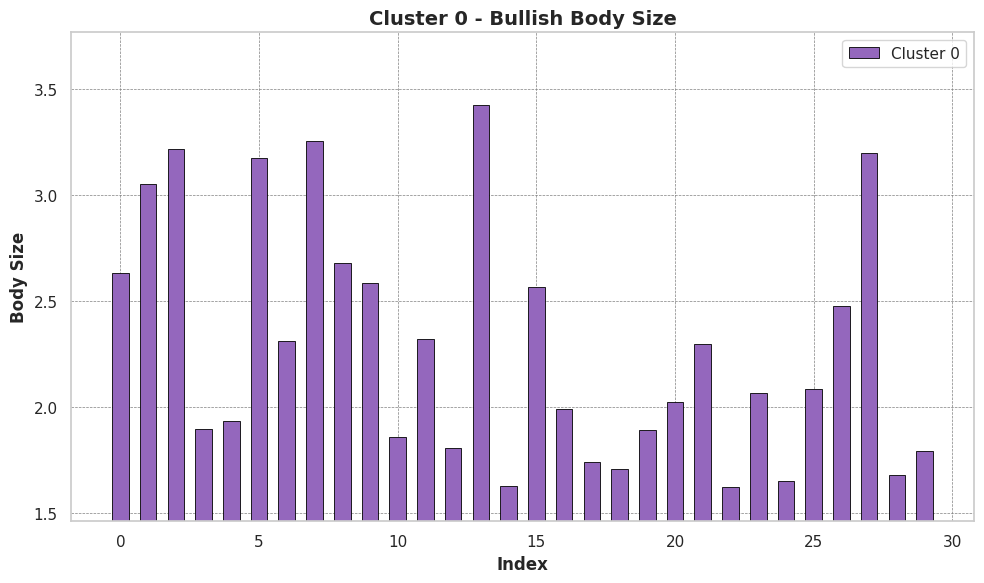

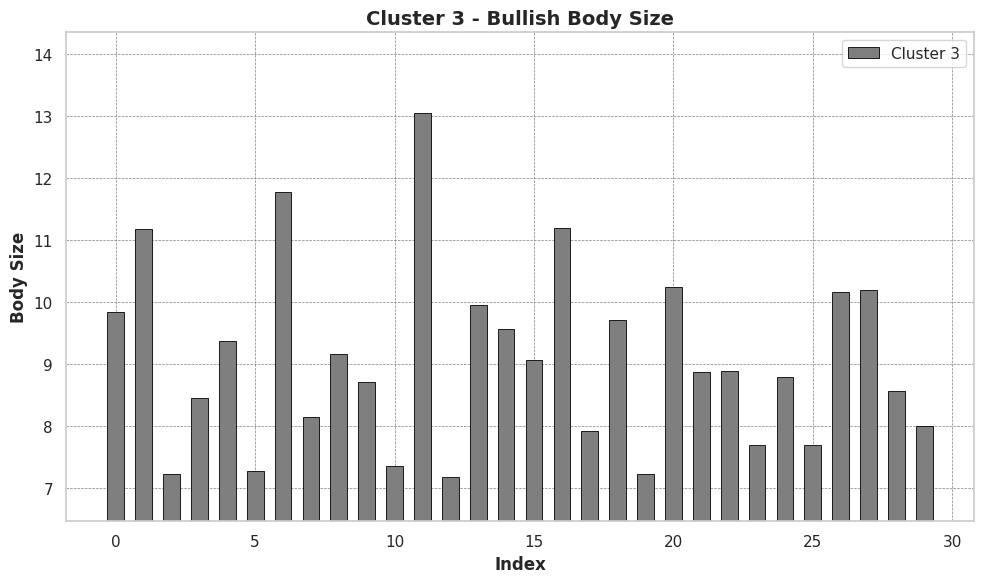

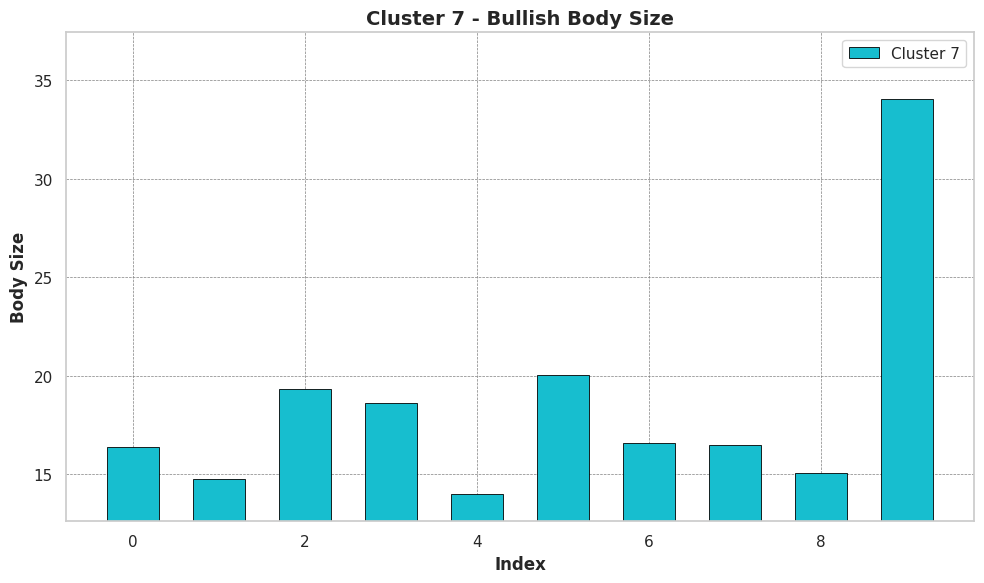

In [ ]:
sns.set(style="whitegrid")

# Unique clusters
clusters = body_data['Cluster'].unique()
colors = sns.color_palette("tab10", len(clusters))

# Function to plot the data
def plot_cluster_data(data, trend_type):
    for i, cluster in enumerate(clusters):
        cluster_data = data[data['Cluster'] == cluster].iloc[:30].reset_index(drop=True)

        if not cluster_data.empty:
            plt.figure(figsize=(10, 6))
            plt.bar(cluster_data.index, cluster_data['L_body'], width=0.6,
                    color=colors[i], edgecolor='black', linewidth=0.6)

            min_value = cluster_data['L_body'].min()
            max_value = cluster_data['L_body'].max()

            plt.ylim(min_value * 0.9, max_value * 1.1)
            plt.title(f'Cluster {cluster} - {trend_type} Body Size', fontsize=14, fontweight='bold')
            plt.xlabel('Index', fontsize=12)
            plt.ylabel('Body Size', fontsize=12)
            plt.grid(visible=True, which='both', color='grey', linestyle='--', linewidth=0.5)
            plt.legend([f'Cluster {cluster}'], loc='upper right')
            plt.tight_layout()
            plt.show()

# Plot bearish clusters
plot_cluster_data(bearish_data, "Bearish")

# Plot bullish clusters
plot_cluster_data(bullish_data, "Bullish")

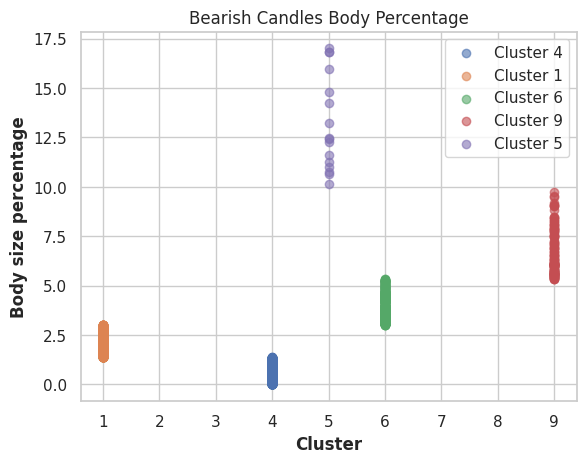

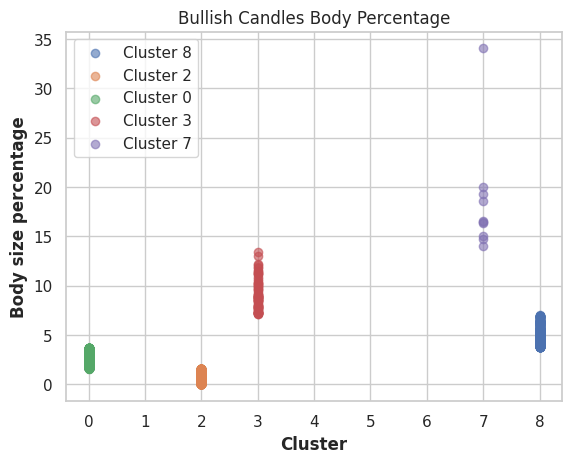

In [ ]:
for cluster_bearish in clusters_bearish:
    cluster_data = bearish_data[bearish_data['Cluster'] == cluster_bearish]

    plt.scatter([cluster_bearish] * len(cluster_data), cluster_data['L_body'], label=f'Cluster {cluster_bearish}', alpha=0.6)

plt.title('Bearish Candles Body Percentage')
plt.ylabel('Body size percentage')
plt.xlabel('Cluster')
plt.legend()
plt.show()

for cluster_bullish in clusters_bullish:
    cluster_data2 = bullish_data[bullish_data['Cluster'] == cluster_bullish]
    plt.scatter([cluster_bullish] * len(cluster_data2), cluster_data2['L_body'], label=f'Cluster {cluster_bullish}', alpha=0.6)

plt.title('Bullish Candles Body Percentage')
plt.ylabel('Body size percentage')
plt.xlabel('Cluster')
plt.legend()
plt.show()

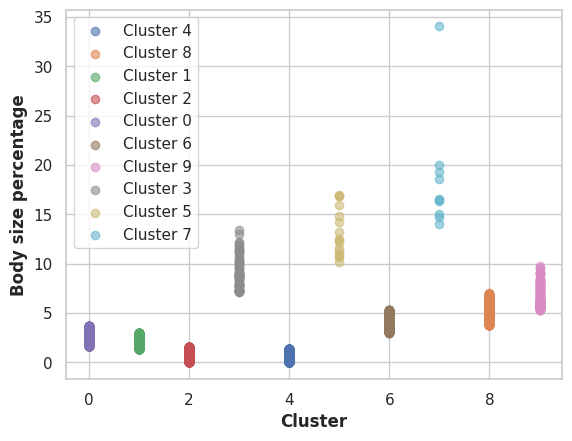

In [ ]:
for cluster in clusters:
    cluster_data = body_data[body_data['Cluster'] == cluster]

    plt.scatter([cluster] * len(cluster_data), cluster_data['L_body'], label=f'Cluster {cluster}', alpha=0.6)

plt.ylabel('Body size percentage')
plt.xlabel('Cluster')
plt.legend()
plt.show()

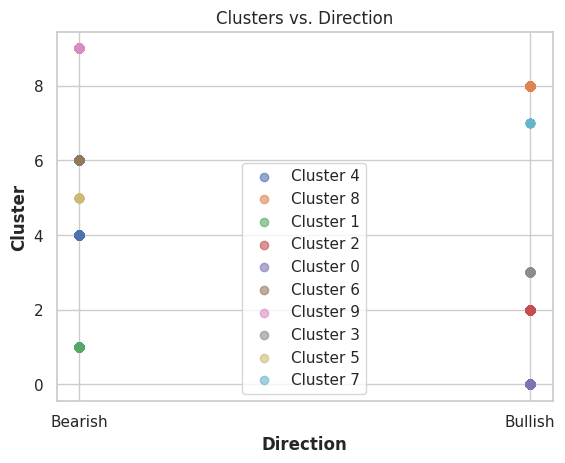

In [ ]:
for cluster in body_data['Cluster'].unique():
    cluster_data = body_data[body_data['Cluster'] == cluster]

    plt.scatter(cluster_data['W_B'], [cluster] * len(cluster_data), label=f'Cluster {cluster}', alpha=0.6)


plt.title('Clusters vs. Direction')
plt.xlabel('Direction')
plt.ylabel('Cluster')
plt.legend()
plt.show()

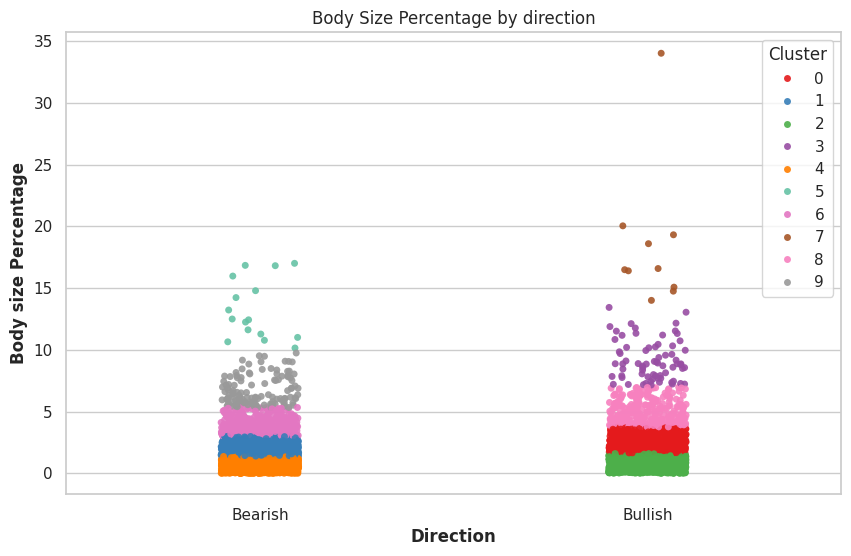

In [ ]:
def plot_clusters_stacked_by_wb_stripplot(body_data):
    plt.figure(figsize=(10, 6))
    vibrant_palette = sns.color_palette(
        [
            "#e41a1c",  # red
            "#377eb8",  # blue
            "#4daf4a",  # green
            "#984ea3",  # purple
            "#ff7f00",  # orange
            "#66c2a5",   # teal
            "#e377c2",  # Raspberry yogurt pink
            "#a65628",  # brown
            "#f781bf",  # pink
            "#999999",  # grey
            ]
        ) #Creating own pallet of colors for better visualization
    sns.stripplot(data=body_data, x='W_B', y='L_body', hue='Cluster', dodge=False, jitter=0.1, palette= vibrant_palette, alpha=0.9)

    plt.title('Body Size Percentage by direction')
    plt.xlabel('Direction')
    plt.ylabel('Body size Percentage')
    plt.legend(title='Cluster')
    plt.show()

plot_clusters_stacked_by_wb_stripplot(body_data)

In [ ]:
body_data['Cluster'].value_counts()

,count
Cluster,
4,1301
2,1268
0,824
1,786
6,358
8,292
9,119
3,70
5,16


## Clustering the upper wick

Now, we will group the upper shadow into 4 distinct clusters. Since our data examples are already classified as bullish or bearish, there is no point on using 8 no classes.

In [ ]:
cluster2_data = pd.DataFrame({
    'L_upper': numeric_data['L_upper'],
})
cluster2_data

,L_upper
0,1.404016
1,0.197899
2,2.033220
3,1.279435
4,0.031056
...,...
5039,0.000000
5040,0.000000
5041,1.530360
5042,0.882329


In [ ]:
kmeans = KMeans(n_clusters = 5, random_state = 42)
kmeans.fit(cluster2_data)
cluster2_data['sub_Cluster_1'] = kmeans.labels_

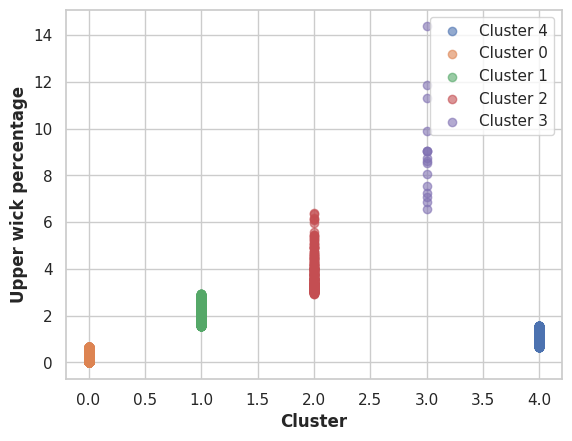

In [ ]:
clusters = cluster2_data['sub_Cluster_1'].unique()
for cluster in clusters:
    cluster_data = cluster2_data[cluster2_data['sub_Cluster_1'] == cluster]
    plt.scatter([cluster] * len(cluster_data), cluster_data['L_upper'], label=f'Cluster {cluster}', alpha=0.6)

plt.xlabel('Cluster')
plt.ylabel('Upper wick percentage')
plt.legend()
plt.show()

## Clustering Lower wick
And last but not least we are going to classify the lower wick in 4 different classes.

In [ ]:
cluster3_data = pd.DataFrame({
    'L_lower': numeric_data['L_lower'],
})
cluster3_data

,L_lower
0,0.464671
1,0.156235
2,0.629089
3,2.742374
4,1.459706
...,...
5039,0.000000
5040,1.533730
5041,0.000000
5042,1.058812


In [ ]:
kmeans.fit(cluster3_data)
cluster3_data['sub_Cluster_2'] = kmeans.labels_

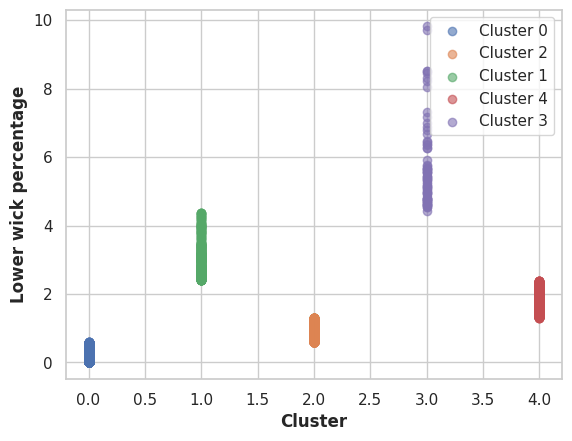

In [ ]:
clusters = cluster3_data['sub_Cluster_2'].unique()
for cluster in clusters:
    cluster_data = cluster3_data[cluster3_data['sub_Cluster_2'] == cluster]
    plt.scatter([cluster] * len(cluster_data), cluster_data['L_lower'], label=f'Cluster {cluster}', alpha=0.6)

plt.xlabel('Cluster')
plt.ylabel('Lower wick percentage')
plt.legend()
plt.show()

In [ ]:
final_data = pd.DataFrame({
    'Body_class': body_data['Cluster'],
    'Upper_class': cluster2_data['sub_Cluster_1'],
    'Lower_class': cluster3_data['sub_Cluster_2'],
})
final_data

,Body_class,Upper_class,Lower_class
0,4,4,0
1,8,0,0
2,1,1,2
3,2,4,1
4,2,0,4
...,...,...,...
5039,6,0,0
5040,6,0,4
5041,6,4,0
5042,4,4,2


## Combining Clusters

Now that we have all the different classifications for each of our data points, we can compile them into a code. This code will be remapped to make it more user-friendly and easier to analyze. Each different code is interpreted as a new cluster.

In [ ]:
combined_cluster = (final_data['Body_class'].astype(str) + final_data['Upper_class'].astype(str) + final_data['Lower_class'].astype(str))
combined_cluster

,0
0,440
1,800
2,112
3,241
4,204
...,...
5039,600
5040,604
5041,640
5042,442


In [ ]:
np.unique(combined_cluster)

array(['000', '001', '002', '003', '004', '010', '011', '012', '014',
       '020', '021', '022', '023', '024', '030', '032', '040', '041',
       '042', '043', '044', '100', '101', '102', '103', '104', '110',
       '111', '112', '113', '114', '120', '121', '122', '124', '132',
       '134', '140', '141', '142', '143', '144', '200', '201', '202',
       '203', '204', '210', '211', '212', '213', '214', '220', '221',
       '222', '224', '230', '232', '240', '241', '242', '243', '244',
       '300', '301', '302', '303', '304', '310', '311', '312', '314',
       '320', '322', '324', '331', '334', '340', '342', '344', '400',
       '401', '402', '403', '404', '410', '411', '412', '413', '414',
       '420', '421', '422', '423', '424', '430', '434', '440', '441',
       '442', '443', '444', '500', '501', '502', '503', '504', '514',
       '520', '541', '542', '544', '600', '601', '602', '603', '604',
       '610', '611', '612', '614', '620', '622', '624', '640', '641',
       '642', '644',

In [ ]:
new_cluster = pd.factorize(combined_cluster)[0]
np.unique(new_cluster)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173])

As shown above, we have a total of 174 classes, each containing at least one example. Although we have a total of 250 possible combinations, our current dataset encompasses only 174 of these combinations. With a larger dataset, we could potentially capture the full range.

In [ ]:
data['Cluster'] = new_cluster
data

,Date,Open,High,Low,Close,Body_size,Upper_shadow,Lower_shadow,L_body,L_upper,L_lower,W_B,Cluster
0,2022-06-03 00:00:00+00:00,200.139999,202.949997,198.050003,198.979996,1.160003,2.809998,0.929993,0.579596,1.404016,0.464671,-10,0
1,2022-06-02 00:00:00+00:00,192.020004,205.470001,191.720001,205.089996,13.069992,0.380005,0.300003,6.806578,0.197899,0.156235,10,1
2,2022-06-01 00:00:00+00:00,198.699997,202.740005,191.660004,192.910004,5.789993,4.040008,1.250000,2.913937,2.033220,0.629089,-10,2
3,2022-05-31 00:00:00+00:00,196.179993,199.949997,190.800003,197.440002,1.260009,2.509995,5.379990,0.642272,1.279435,2.742374,10,3
4,2022-05-27 00:00:00+00:00,193.190002,195.250000,190.369995,195.190002,2.000000,0.059998,2.820007,1.035250,0.031056,1.459706,10,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5039,2002-05-30 00:00:00+00:00,1.107857,1.107857,1.071429,1.071429,0.036428,0.000000,0.000000,3.288150,0.000000,0.000000,-10,10
5040,2002-05-29 00:00:00+00:00,1.164286,1.164286,1.085714,1.103571,0.060715,0.000000,0.017857,5.214784,0.000000,1.533730,-10,68
5041,2002-05-28 00:00:00+00:00,1.213571,1.232143,1.157143,1.157143,0.056428,0.018572,0.000000,4.649749,1.530360,0.000000,-10,11
5042,2002-05-24 00:00:00+00:00,1.214286,1.225000,1.197143,1.210000,0.004286,0.010714,0.012857,0.352965,0.882329,1.058812,-10,29


In [ ]:
cluster_data = data.head(30)
cluster_data['Cluster'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [ ]:
cluster_data['Cluster'].value_counts()

,count
Cluster,
1,2
4,2
10,2
8,2
12,2
15,2
2,1
0,1
7,1


## Results - plotting the graphs

In [ ]:
def plot_candlestick_with_clusters(data, num_samples, cluster=None):
    candlestick_data = data.tail(num_samples).copy()

    # Filtering
    if cluster is not None:
        candlestick_data = candlestick_data[candlestick_data['Cluster'] == cluster]

    candlestick_data['Date'] = pd.to_datetime(candlestick_data['Date'])
    candlestick_data['Date'] = candlestick_data['Date'].apply(mdates.date2num)  # Convert to matplotlib date format
    ohlc = candlestick_data[['Date', 'Open', 'High', 'Low', 'Close']]
    fig, ax = plt.subplots(figsize=(10, 6))
    candlestick_ohlc(ax, ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)

    wick_tops = candlestick_data['High'] * 1.01  # Add a small margin to show the classification number (1% higher than the actual wick top)
    for date, top, cluster_value in zip(candlestick_data['Date'], wick_tops, candlestick_data['Cluster']):
        ax.text(date, top, str(cluster_value), ha='center', va='bottom', fontsize=9, color='black', fontweight='bold')

    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Last 30 days graph

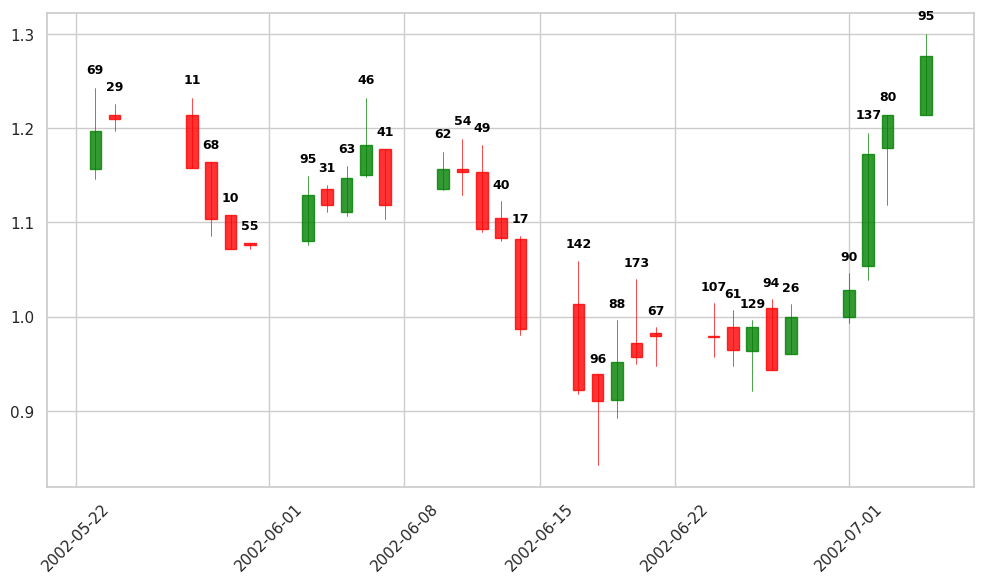

In [ ]:
plot_candlestick_with_clusters(data, 30)

### Random single clusters plot

In [ ]:
def plot_candlestick_single_clusters(data, num_samples, cluster=None):
    candlestick_data = data.copy()

    if cluster is not None:
        candlestick_data = candlestick_data[candlestick_data['Cluster'] == cluster]

    candlestick_data = candlestick_data.head(num_samples)

    if 'Date' in candlestick_data.columns:
        candlestick_data['Date'] = pd.to_datetime(candlestick_data['Date'])
        candlestick_data.set_index('Date', inplace=True)
    else:
        raise ValueError("The 'Date' column is missing in the data.")

    mpf_data = candlestick_data[['Open', 'High', 'Low', 'Close']]

    title = f"Candlestick Chart for Cluster {cluster}" if cluster is not None else "Candlestick Chart"

    mpf.plot(mpf_data, type='candle', style='charles', title=title, volume=False)

In [ ]:
random_values = [random.randint(0, 97) for _ in range(10)]
sorted_values = sorted(random_values)
sorted_values

[0, 3, 3, 17, 35, 35, 38, 55, 58, 61]

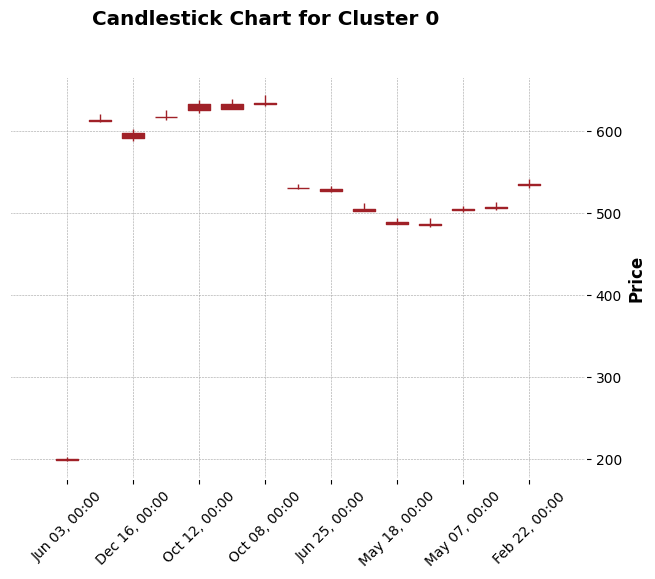

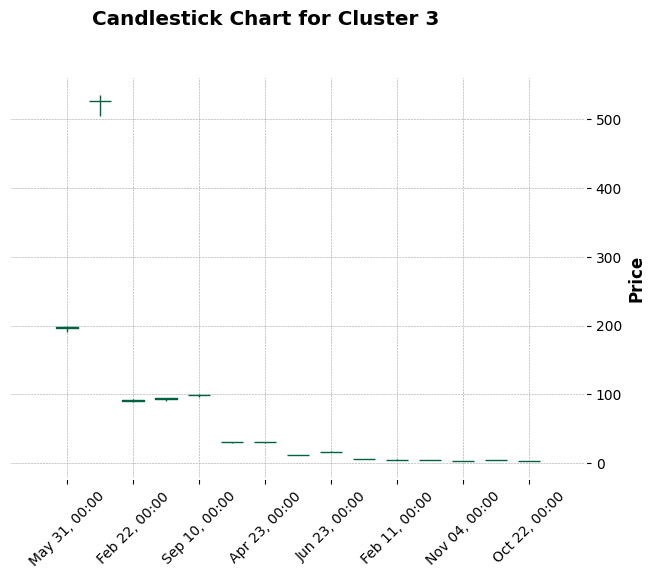

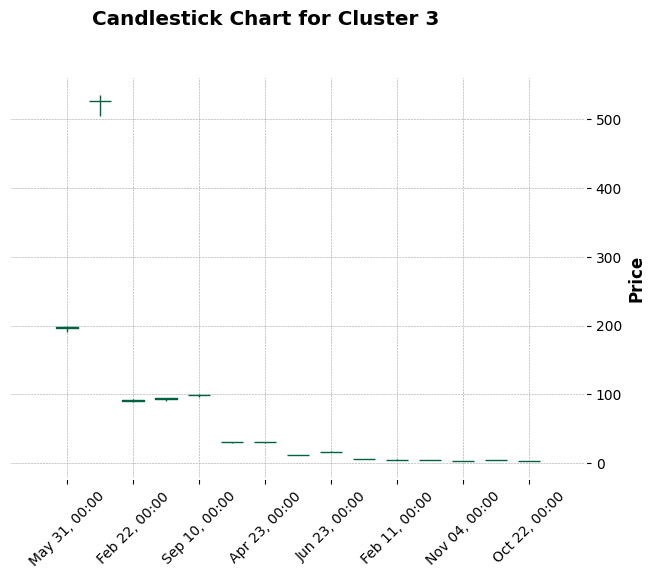

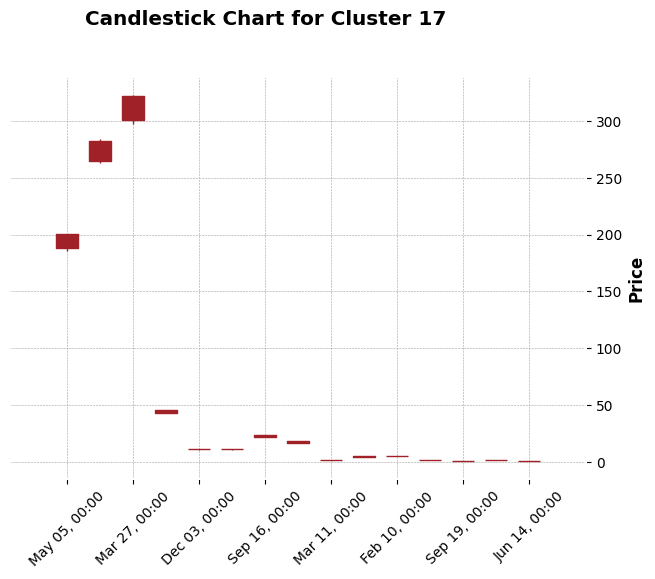

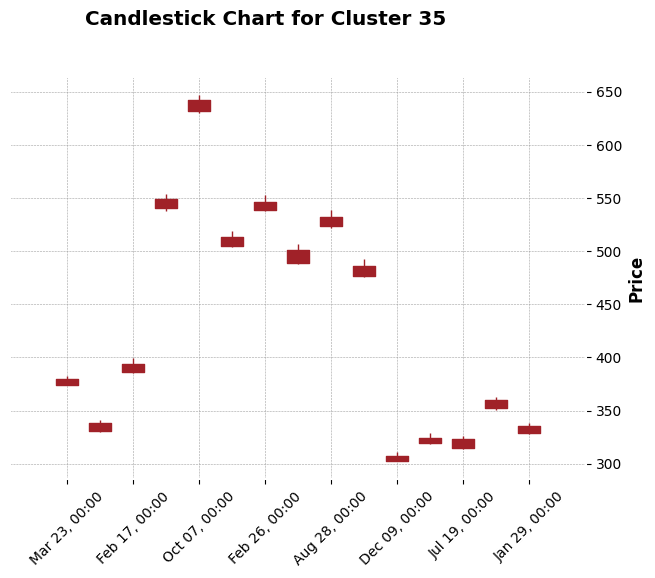

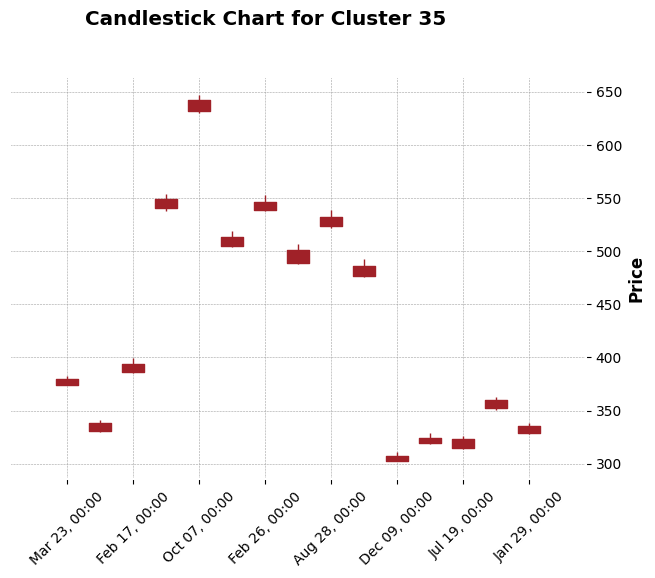

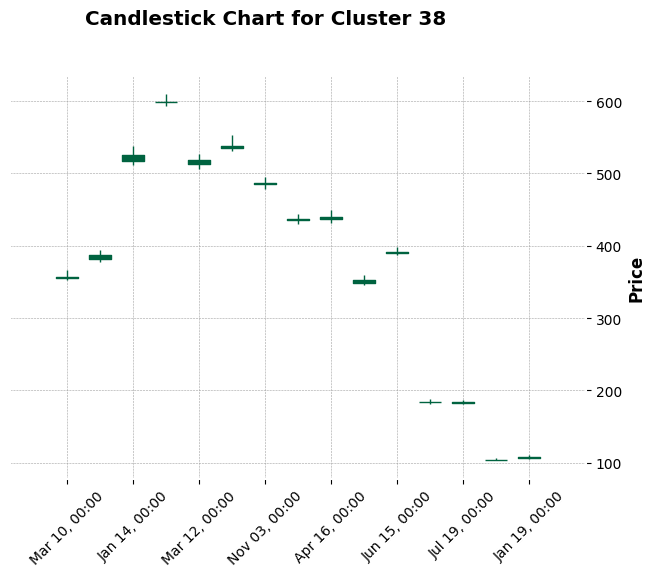

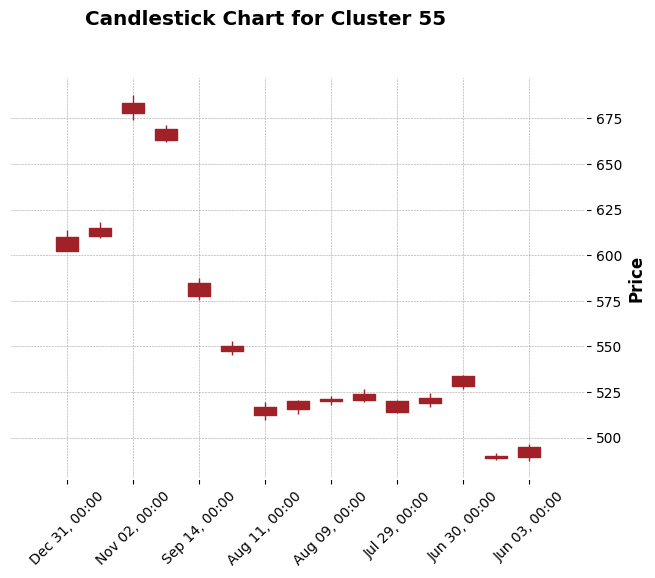

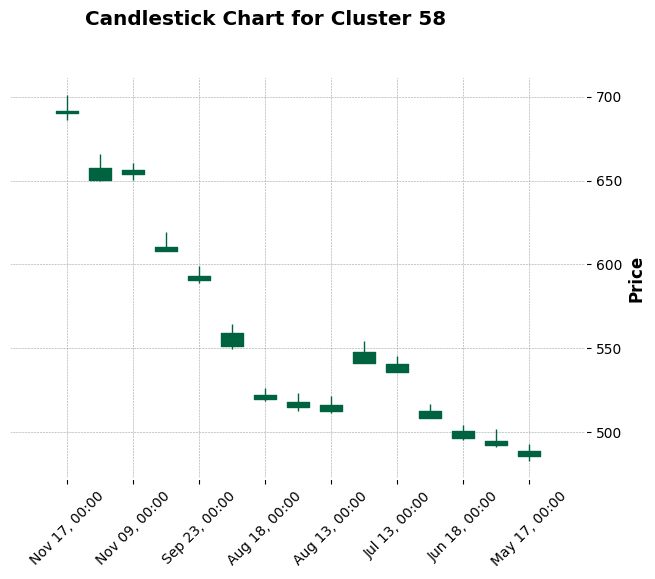

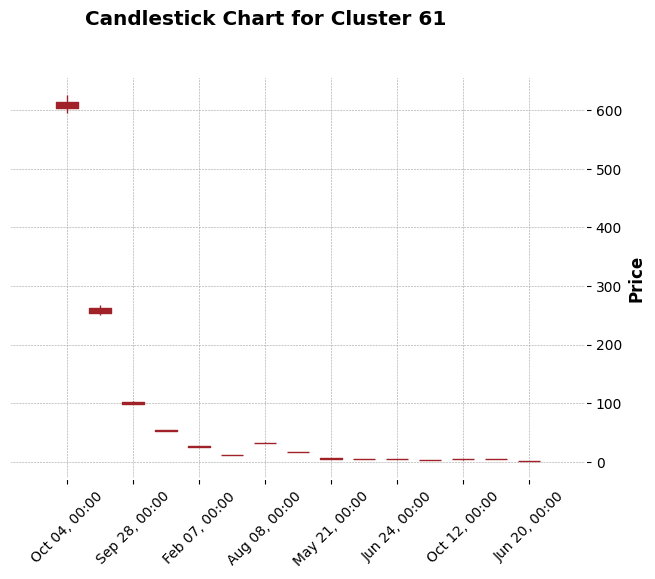

In [ ]:
for i in sorted_values:
  plot_candlestick_single_clusters(data, 15, i)

### Plot of a random date

In [ ]:
def plot_candlestick_with_clusters_rand(data, num_samples=30):
    # Randomly select a start index within the data
    random_start = np.random.randint(0, len(data) - num_samples)
    candlestick_data = data.iloc[random_start:random_start + num_samples].copy()

    candlestick_data['Date'] = pd.to_datetime(candlestick_data['Date'])
    candlestick_data['Date'] = candlestick_data['Date'].apply(mdates.date2num)
    ohlc = candlestick_data[['Date', 'Open', 'High', 'Low', 'Close']]
    fig, ax = plt.subplots(figsize=(10, 6))
    candlestick_ohlc(ax, ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)

    # Adding cluster values as text labels above each candlestick
    wick_tops = candlestick_data['High'] * 1.01
    for date, top, cluster_value in zip(candlestick_data['Date'], wick_tops, candlestick_data['Cluster']):
        ax.text(date, top, str(cluster_value), ha='center', va='bottom', fontsize=9, color='black', fontweight='bold')

    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

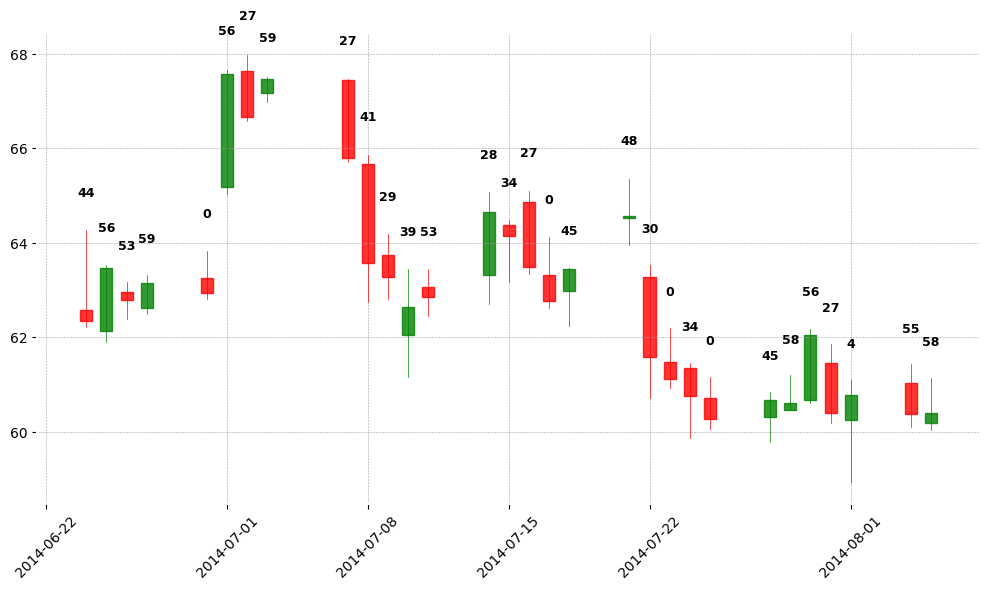

In [ ]:
plot_candlestick_with_clusters_rand(data, 30)

In [ ]:
#Saving the best results
if (selection == 1):
  clustered_data = pd.read_excel('NFLX.xlsx')
  clustered_data['Cluster'] = data['Cluster']
  output_file = '/content/NFLX_Clustered_Data.xlsx'
  clustered_data.to_excel(output_file, index=False)
  print(f"Clustered data saved to {output_file}")
  clustered_data
elif (selection == 2):
  clustered_data = pd.read_csv('AAPL.csv')
  clustered_data['Cluster'] = data['Cluster']
  output_file = '/content/AAPL_Clustered_Data.xlsx'
  clustered_data.to_excel(output_file, index=False)
  print(f"Clustered data saved to {output_file}")
elif (selection == 3):
  clustered_data = pd.read_csv('NVIDIA.csv')
  clustered_data['Cluster'] = data['Cluster']
  output_file = '/content/NVIDIA_Clustered_Data.xlsx'
  clustered_data.to_excel(output_file, index=False)
  print(f"Clustered data saved to {output_file}")
elif (selection == 4):
  clustered_data = pd.read_csv('Intel.csv')
  clustered_data['Cluster'] = data['Cluster']
  output_file = '/content/Intel_Clustered_Data.xlsx'
  clustered_data.to_excel(output_file, index=False)
  print(f"Clustered data saved to {output_file}")
elif (selection == 5):
  clustered_data = pd.read_csv('GOOGLE.csv')
  clustered_data['Cluster'] = data['Cluster']
  output_file = '/content/Google_Clustered_Data.xlsx'
  clustered_data.to_excel(output_file, index=False)
  print(f"Clustered data saved to {output_file}")
else:
  print("Error")

Clustered data saved to /content/NFLX_Clustered_Data.xlsx


In [ ]:
def plot_candlestick_with_clusters_interactive(data, num_samples, cluster=None):
    # Filter data
    candlestick_data = data.head(num_samples).copy()
    if cluster is not None:
        candlestick_data = candlestick_data[candlestick_data['Cluster'] == cluster]

    candlestick_data['Date'] = pd.to_datetime(candlestick_data['Date'])

    # Create candlestick chart
    fig = go.Figure()
    fig.add_trace(go.Candlestick(
        x=candlestick_data['Date'],
        open=candlestick_data['Open'],
        high=candlestick_data['High'],
        low=candlestick_data['Low'],
        close=candlestick_data['Close'],
        name='Candlesticks',
        increasing_line_color='green',
        decreasing_line_color='red'
    ))

    # Add clusters as scatter plot markers above candles
    fig.add_trace(go.Scatter(
        x=candlestick_data['Date'],
        y=candlestick_data['High'] * 1.05,  # Offset above the high values
        mode='text',
        text=candlestick_data['Cluster'],
        textfont=dict(color='black', size=10, family="Arial"),
        name='Cluster',
        showlegend=False
    ))

    # Update layout
    fig.update_layout(
        title="Candlestick Chart with Clusters and Hidden States",
        xaxis_title="Date",
        yaxis_title="Price",
        xaxis_rangeslider_visible=False,  # Optional: Hide range slider
        template="plotly_white",
    )

    # Show plot
    fig.show()

In [ ]:
plot_candlestick_with_clusters_interactive(data, 5044)